## Introduction & Objectives

In [1]:

# GAN Loss Comparison on MedMNIST Dataset

''''''In this notebook, we compare the performance of three different GAN variants:
- Least Squares GAN (LS-GAN)
- Wasserstein GAN (WGAN)
- Wasserstein GAN with Gradient Penalty (WGAN-GP)

We will evaluate the models using:
- Inception Score (IS)
- Fréchet Inception Distance (FID)
- Visual quality of generated images

Dataset: [MedMNIST](https://medmnist.com/)''''


SyntaxError: unterminated triple-quoted string literal (detected at line 13) (3279345359.py, line 13)

## Imports & Setup

In [1]:
pip install torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [2]:
!pip install torchmetrics[image]


In [3]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import random

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


2025-04-11 19:31:06.035606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744399866.444001      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744399866.565097      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


## Dataset Preparation

In [4]:
# Install MedMNIST if not already installed
!pip install -q medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


100%|██████████| 35.5M/35.5M [00:02<00:00, 12.8MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


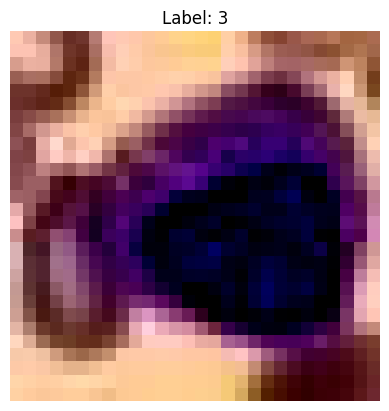

In [5]:
# Import MedMNIST and tools
from medmnist import INFO, Evaluator
from medmnist.dataset import PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Dataset setup
data_flag = 'bloodmnist'  # You can choose other variants too: bloodmnist, pneumoniamnist, etc.
download = True

# Load info
info = INFO[data_flag]
DataClass = getattr(__import__('medmnist.dataset', fromlist=[info['python_class']]), info['python_class'])
n_channels = info['n_channels']
n_classes = len(info['label'])

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # 3-channel normalization
])


# Load dataset
train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check sample image
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1, 2, 0))  # convert from CHW to HWC
plt.title(f"Label: {labels[0].item()}")
plt.axis("off")
plt.show()


## Model Architectures

In [6]:

# Define Generator and Discriminator models

class Generator(nn.Module):
    def __init__(self, nz=100, nc=3):  # nc=3 for RGB
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 128, 7, 1, 0),  # Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, nc, 4, 2, 1),  # Output: (3, 28, 28)
            nn.Tanh()  # [-1, 1] output range
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, nc=3):  # Set nc=3 for RGB
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1),  # Input: (3, 28, 28)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),  # (64, 14, 14) -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
        )

    def forward(self, x):
        return self.main(x).squeeze()


In [7]:
# Define new sections for LS-GAN Training

# LS-GAN uses Least Squares Loss for the discriminator
def ls_gan_loss(output, target):
    return 0.5 * torch.mean((output - target) ** 2)

# Initialize models, optimizers
nz = 100
G_ls = Generator(nz=nz).to(device)
D_ls = Discriminator().to(device)

optimizerG = optim.Adam(G_ls.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(D_ls.parameters(), lr=0.0002, betas=(0.5, 0.999))

writer_ls = SummaryWriter(log_dir='runs/LSGAN')

num_epochs = 50
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        b_size = real_images.size(0)
        real_labels = torch.ones(b_size, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        # Train Discriminator
        optimizerD.zero_grad()
        output_real = D_ls(real_images)
        loss_real = ls_gan_loss(output_real, real_labels)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G_ls(noise)
        output_fake = D_ls(fake_images.detach())
        loss_fake = ls_gan_loss(output_fake, fake_labels)

        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizerD.step()

        # Train Generator
        optimizerG.zero_grad()
        output = D_ls(fake_images)
        g_loss = ls_gan_loss(output, real_labels)
        g_loss.backward()
        optimizerG.step()

    print(f"[{epoch+1}/{num_epochs}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    with torch.no_grad():
        fake = G_ls(fixed_noise).detach().cpu()
    img_grid = make_grid(fake, normalize=True)
    writer_ls.add_image('LSGAN Generated Images', img_grid, global_step=epoch)
    writer_ls.add_scalars('Loss/LSGAN', {'Generator': g_loss.item(), 'Discriminator': d_loss.item()}, epoch)

writer_ls.close()




[1/50] D Loss: 0.2079, G Loss: 0.7410
[2/50] D Loss: 0.1964, G Loss: 0.3184
[3/50] D Loss: 0.2416, G Loss: 0.1312
[4/50] D Loss: 0.1148, G Loss: 0.1541
[5/50] D Loss: 0.1357, G Loss: 0.2843
[6/50] D Loss: 0.1836, G Loss: 0.4434
[7/50] D Loss: 0.1850, G Loss: 0.8630
[8/50] D Loss: 0.2557, G Loss: 0.0308
[9/50] D Loss: 0.0841, G Loss: 0.3836
[10/50] D Loss: 0.1186, G Loss: 0.2454
[11/50] D Loss: 0.0642, G Loss: 0.3545
[12/50] D Loss: 0.0958, G Loss: 0.1433
[13/50] D Loss: 0.0845, G Loss: 0.4016
[14/50] D Loss: 0.0561, G Loss: 0.2529
[15/50] D Loss: 0.1597, G Loss: 0.1294
[16/50] D Loss: 0.0723, G Loss: 0.2570
[17/50] D Loss: 0.0677, G Loss: 0.3566
[18/50] D Loss: 0.0550, G Loss: 0.3749
[19/50] D Loss: 0.1876, G Loss: 0.1035
[20/50] D Loss: 0.3224, G Loss: 0.1363
[21/50] D Loss: 0.0332, G Loss: 0.6253
[22/50] D Loss: 0.1902, G Loss: 0.1054
[23/50] D Loss: 0.0612, G Loss: 0.5537
[24/50] D Loss: 0.0923, G Loss: 0.4862
[25/50] D Loss: 0.0604, G Loss: 0.2945
[26/50] D Loss: 0.0538, G Loss: 0.

In [8]:
# WGAN uses the Wasserstein loss and weight clipping
def wgan_loss(output, is_real=True):
    return -output.mean() if is_real else output.mean()

# Initialize models and optimizers
G_wgan = Generator(nz=nz).to(device)
D_wgan = Discriminator().to(device)

optimizerG = optim.RMSprop(G_wgan.parameters(), lr=0.00005)
optimizerD = optim.RMSprop(D_wgan.parameters(), lr=0.00005)

writer_wgan = SummaryWriter(log_dir='runs/WGAN')
clip_value = 0.01  # for weight clipping

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Train Discriminator more times than Generator (5 times here)
        for _ in range(5):
            optimizerD.zero_grad()
            output_real = D_wgan(real_images)
            d_loss_real = wgan_loss(output_real, is_real=True)

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = G_wgan(noise).detach()
            output_fake = D_wgan(fake_images)
            d_loss_fake = wgan_loss(output_fake, is_real=False)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizerD.step()

            # Weight clipping
            for p in D_wgan.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Train Generator
        optimizerG.zero_grad()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G_wgan(noise)
        output = D_wgan(fake_images)
        g_loss = wgan_loss(output, is_real=True)
        g_loss.backward()
        optimizerG.step()

    print(f"[{epoch+1}/{num_epochs}] WGAN D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    with torch.no_grad():
        fake = G_wgan(fixed_noise).detach().cpu()
    img_grid = make_grid(fake, normalize=True)
    writer_wgan.add_image('WGAN Generated Images', img_grid, global_step=epoch)
    writer_wgan.add_scalars('Loss/WGAN', {'Generator': g_loss.item(), 'Discriminator': d_loss.item()}, epoch)

writer_wgan.close()



[1/50] WGAN D Loss: -0.2272, G Loss: 0.1519
[2/50] WGAN D Loss: -0.1520, G Loss: 0.0494
[3/50] WGAN D Loss: -0.1352, G Loss: 0.1176
[4/50] WGAN D Loss: -0.1284, G Loss: 0.0415
[5/50] WGAN D Loss: -0.1194, G Loss: 0.0529
[6/50] WGAN D Loss: -0.0917, G Loss: 0.0932
[7/50] WGAN D Loss: -0.0883, G Loss: 0.0293
[8/50] WGAN D Loss: -0.0806, G Loss: 0.0748
[9/50] WGAN D Loss: -0.0575, G Loss: 0.0671
[10/50] WGAN D Loss: -0.0855, G Loss: 0.0895
[11/50] WGAN D Loss: -0.0528, G Loss: 0.0868
[12/50] WGAN D Loss: -0.0705, G Loss: 0.0927
[13/50] WGAN D Loss: -0.0756, G Loss: 0.0979
[14/50] WGAN D Loss: -0.0693, G Loss: 0.0809
[15/50] WGAN D Loss: -0.0674, G Loss: 0.0887
[16/50] WGAN D Loss: -0.0653, G Loss: 0.0801
[17/50] WGAN D Loss: -0.0601, G Loss: 0.1026
[18/50] WGAN D Loss: -0.0790, G Loss: 0.0330
[19/50] WGAN D Loss: -0.0652, G Loss: 0.0474
[20/50] WGAN D Loss: -0.0613, G Loss: 0.0495
[21/50] WGAN D Loss: -0.0675, G Loss: 0.0853
[22/50] WGAN D Loss: -0.0629, G Loss: 0.0871
[23/50] WGAN D Loss

In [9]:
# WGAN-GP uses gradient penalty instead of weight clipping to enforce the Lipschitz constraint

def gradient_penalty(D, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

lambda_gp = 10  # Regularization weight for the gradient penalty

# Initialize Generator and Discriminator
G_gp = Generator(nz=nz).to(device)
D_gp = Discriminator().to(device)

# Use Adam optimizers with beta settings for WGAN-GP
optimizerG = optim.Adam(G_gp.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = optim.Adam(D_gp.parameters(), lr=0.0001, betas=(0.0, 0.9))

# TensorBoard writer
writer_gp = SummaryWriter(log_dir='runs/WGAN_GP')

# Training Loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Train Discriminator multiple times per Generator iteration
        for _ in range(5):
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = G_gp(noise).detach()

            d_real = D_gp(real_images)
            d_fake = D_gp(fake_images)

            gp = gradient_penalty(D_gp, real_images.data, fake_images.data)

            d_loss = -torch.mean(d_real) + torch.mean(d_fake) + lambda_gp * gp

            optimizerD.zero_grad()
            d_loss.backward()
            optimizerD.step()

        # Train Generator
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G_gp(noise)
        g_loss = -torch.mean(D_gp(fake_images))

        optimizerG.zero_grad()
        g_loss.backward()
        optimizerG.step()

    # Logging
    print(f"[{epoch+1}/{num_epochs}] WGAN-GP D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    with torch.no_grad():
        fake = G_gp(fixed_noise).detach().cpu()
    img_grid = make_grid(fake, normalize=True)
    writer_gp.add_image('WGAN-GP Generated Images', img_grid, global_step=epoch)
    writer_gp.add_scalars('Loss/WGAN-GP', {'Generator': g_loss.item(), 'Discriminator': d_loss.item()}, epoch)

writer_gp.close()


[1/50] WGAN-GP D Loss: -165.0514, G Loss: -6.0178
[2/50] WGAN-GP D Loss: -209.1182, G Loss: -22.5007
[3/50] WGAN-GP D Loss: -150.3692, G Loss: -18.7903
[4/50] WGAN-GP D Loss: -0.5456, G Loss: -23.0750
[5/50] WGAN-GP D Loss: -249.7461, G Loss: -16.7396
[6/50] WGAN-GP D Loss: -357.8444, G Loss: -21.8769
[7/50] WGAN-GP D Loss: -118.2929, G Loss: -29.3343
[8/50] WGAN-GP D Loss: -394.8086, G Loss: -36.3525
[9/50] WGAN-GP D Loss: -242.7707, G Loss: -39.8359
[10/50] WGAN-GP D Loss: -397.9261, G Loss: -49.8953
[11/50] WGAN-GP D Loss: -461.9235, G Loss: -54.5659
[12/50] WGAN-GP D Loss: -255.9880, G Loss: -67.6129
[13/50] WGAN-GP D Loss: 461.8452, G Loss: -68.9494
[14/50] WGAN-GP D Loss: -224.5489, G Loss: -88.7635
[15/50] WGAN-GP D Loss: -381.9683, G Loss: -70.6116
[16/50] WGAN-GP D Loss: -451.8796, G Loss: -74.1663
[17/50] WGAN-GP D Loss: -278.3214, G Loss: -69.9703
[18/50] WGAN-GP D Loss: -5.2233, G Loss: -67.6075
[19/50] WGAN-GP D Loss: -490.0056, G Loss: -74.6604
[20/50] WGAN-GP D Loss: -59

In [10]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import matplotlib.pyplot as plt

# Helper to convert generated or real images to uint8 format [0, 255]
def convert_to_uint8(imgs):
    imgs = (imgs + 1) / 2  # Scale from [-1, 1] to [0, 1]
    imgs = imgs.clamp(0, 1) * 255  # Scale to [0, 255]
    return imgs.to(torch.uint8)
    
def evaluate_model(generator, name="GAN"):
    generator.eval()
    is_metric = InceptionScore(feature=2048).to(device)
    fid_metric = FrechetInceptionDistance(feature=2048).to(device)
    
    with torch.no_grad():
        for _ in range(10):
            noise = torch.randn(64, nz, 1, 1, device=device)
            fake_images = generator(noise)
            fake_images_uint8 = convert_to_uint8(fake_images)  # Convert here
            fid_metric.update(fake_images_uint8, real=False)
            is_metric.update(fake_images_uint8)

        for real_batch, _ in train_loader:
            real_batch = real_batch.to(device)
            real_batch_uint8 = convert_to_uint8(real_batch)  # Convert here
            fid_metric.update(real_batch_uint8, real=True)
            break  # Just one real batch for quick test

    is_mean, is_std = is_metric.compute()
    fid_score = fid_metric.compute()

    print(f"{name} - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid_score:.4f}")
    return is_mean.item(), fid_score.item()


# Evaluate all three models
is_ls, fid_ls = evaluate_model(G_ls, "LSGAN")
is_w, fid_w = evaluate_model(G_wgan, "WGAN")
is_gp, fid_gp = evaluate_model(G_gp, "WGAN-GP")




/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 245MB/s]


LSGAN - Inception Score: 1.0491 ± 0.0032, FID: 242.2650
WGAN - Inception Score: 1.0526 ± 0.0025, FID: 278.6783
WGAN-GP - Inception Score: 1.0169 ± 0.0009, FID: 389.3361


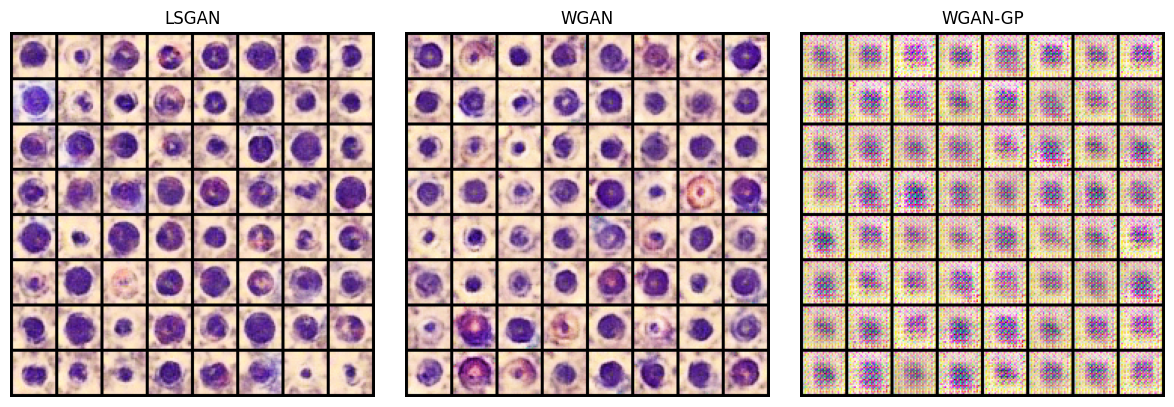

In [11]:
# Visual Comparison
def plot_fake_images(generators, titles):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, (gen, title) in enumerate(zip(generators, titles)):
        with torch.no_grad():
            fake_images = gen(fixed_noise.to(device)).cpu()
        grid = make_grid(fake_images, normalize=True)
        axs[i].imshow(grid.permute(1, 2, 0))
        axs[i].axis("off")
        axs[i].set_title(title)
    plt.tight_layout()
    plt.show()

plot_fake_images(
    [G_ls, G_wgan, G_gp],
    ["LSGAN", "WGAN", "WGAN-GP"]
)

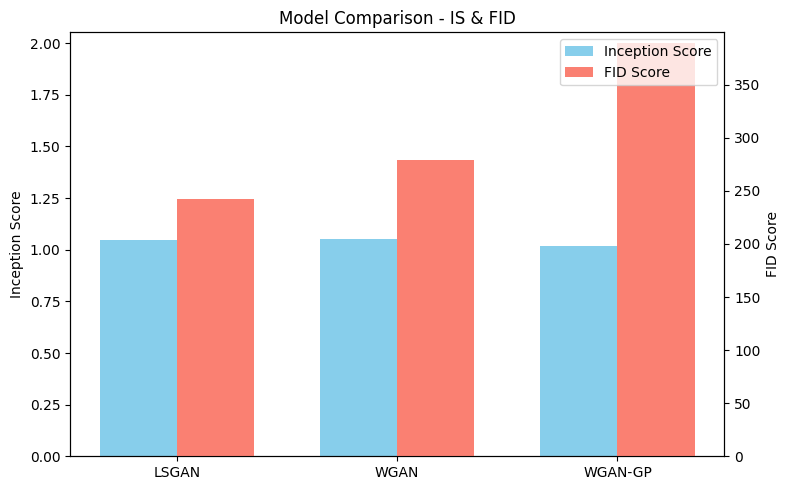

In [12]:
# Bar Chart Comparison
import numpy as np

labels = ["LSGAN", "WGAN", "WGAN-GP"]
IS_scores = [is_ls, is_w, is_gp]
FID_scores = [fid_ls, fid_w, fid_gp]

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))

# Inception Score (higher better)
ax1.bar(x - width/2, IS_scores, width, label='Inception Score', color='skyblue')
ax1.set_ylabel("Inception Score")
ax1.set_ylim(0, max(IS_scores)+1)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title("Model Comparison - IS & FID")

# FID Score (lower better)
ax2 = ax1.twinx()
ax2.bar(x + width/2, FID_scores, width, label='FID Score', color='salmon')
ax2.set_ylabel("FID Score")
ax2.set_ylim(0, max(FID_scores)+10)

# Legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()